In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

2024-03-14 10:37:52.218939: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Plotting Functions

In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.title('Confusion Matrix', fontsize=25)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    heatmap.tick_params(axis='x', which='major', pad=10)
    heatmap.tick_params(axis='y', which='major', pad=10)
    
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Number of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.tick_params(labelsize=15)
    plt.show()
    return conf_matrix

In [3]:
class_labels = [str(i) for i in range(21)]
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]
def plot_normalised_confusion_matrix(conf_matrix):
    class_totals = np.sum(conf_matrix, axis=1)

    normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
    for i in range(len(class_totals)):
        if class_totals[i] != 0:
            normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i] * 100

    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(normalised_conf_matrix, annot=True, fmt='.1f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.title('Normalised Confusion Matrix', fontsize=25)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    cbar = heatmap.collections[0].colorbar
    cbar.set_label('% of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.tick_params(labelsize=15)
    plt.show()
    return normalised_conf_matrix

# 1. Baseline Model

In [4]:
folder = 'pickle'
inner_folder = 'model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)

2024-03-14 10:37:53.851721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 10:37:53.860087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 10:37:53.860278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [5]:
def reset_metrics():
    global acc
    acc = CategoricalAccuracy()

    accuracy_per_class = [CategoricalAccuracy() for _ in range(21)]

In [6]:
test_data = tf.keras.utils.image_dataset_from_directory('Test', image_size=(250, 250))
test_data = test_data.map(lambda image,label: (image/255, label))

Found 51404 files belonging to 21 classes.


In [7]:
def predict(model):
    global y_one_hot, yhat
    y_true = []
    y_pred = []

    for batch in test_data.as_numpy_iterator():
        image, y = batch
        y_one_hot = tf.one_hot(y, 21)
        yhat = model.predict(image, verbose=0)
        acc.update_state(y_one_hot, yhat)
        
        y_true.extend(np.argmax(y_one_hot, axis = 1))
        y_pred.extend(np.argmax(yhat, axis = 1))
    return y_true, y_pred

In [8]:
def create_classification_report(y_true, y_pred):
    print(f'Accuracy:{acc.result().numpy()}')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
    
    print("Classification Report:\n", class_report)
    return class_report

In [9]:
reset_metrics()
y_true, y_pred = predict(model)

2024-03-14 10:38:11.919396: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51404]
	 [[{{node Placeholder/_4}}]]
2024-03-14 10:38:11.919814: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [51404]
	 [[{{node Placeholder/_0}}]]
2024-03-14 10:38:12.390111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-03-14 10:38:13.110743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


### How to read the classification reports:

* Micro averaging computes a global averages, meaning this metric equates all instances, regardless of class, equally
* Macro-average calculates the metric independently for each class and then takes the average, meaning this metric treats all classes equally (instances between classes are not treated equally)
    * Note that the balanced accuracy metric is equivalent to the macro average recall score
* Weighted average calculates the metric for each class independently and then takes the weighted average based on the support of each class.

In [10]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.744747519493103
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         2
         ART       0.72      0.83      0.77      5889
         BAS       0.32      0.14      0.20       132
         BLA       0.61      0.71      0.65      3591
         EBO       0.88      0.91      0.89      8218
         EOS       0.87      0.86      0.86      1764
         FGC       0.08      0.07      0.08        14
         HAC       0.26      0.16      0.20       122
         KSC       0.00      0.00      0.00        12
         LYI       0.00      0.00      0.00        19
         LYT       0.82      0.83      0.82      7872
         MMZ       0.24      0.22      0.23       916
         MON       0.46      0.45      0.45      1212
         MYB       0.52      0.41      0.46      1967
         NGB       0.52      0.57      0.54      2990
         NGS       0.84      0.84      0.84      8826
         NIF       0.40      0

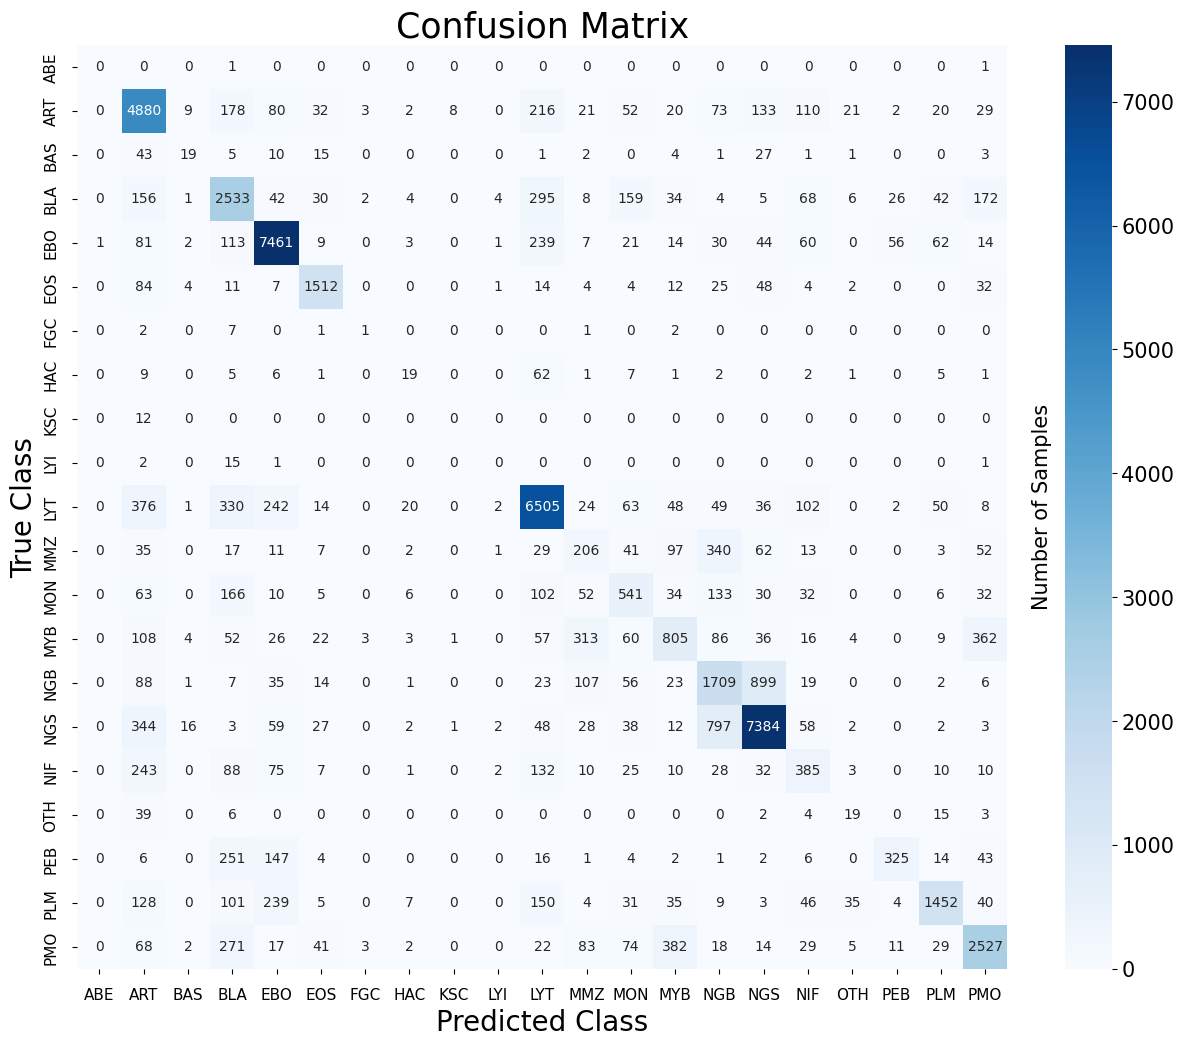

In [11]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

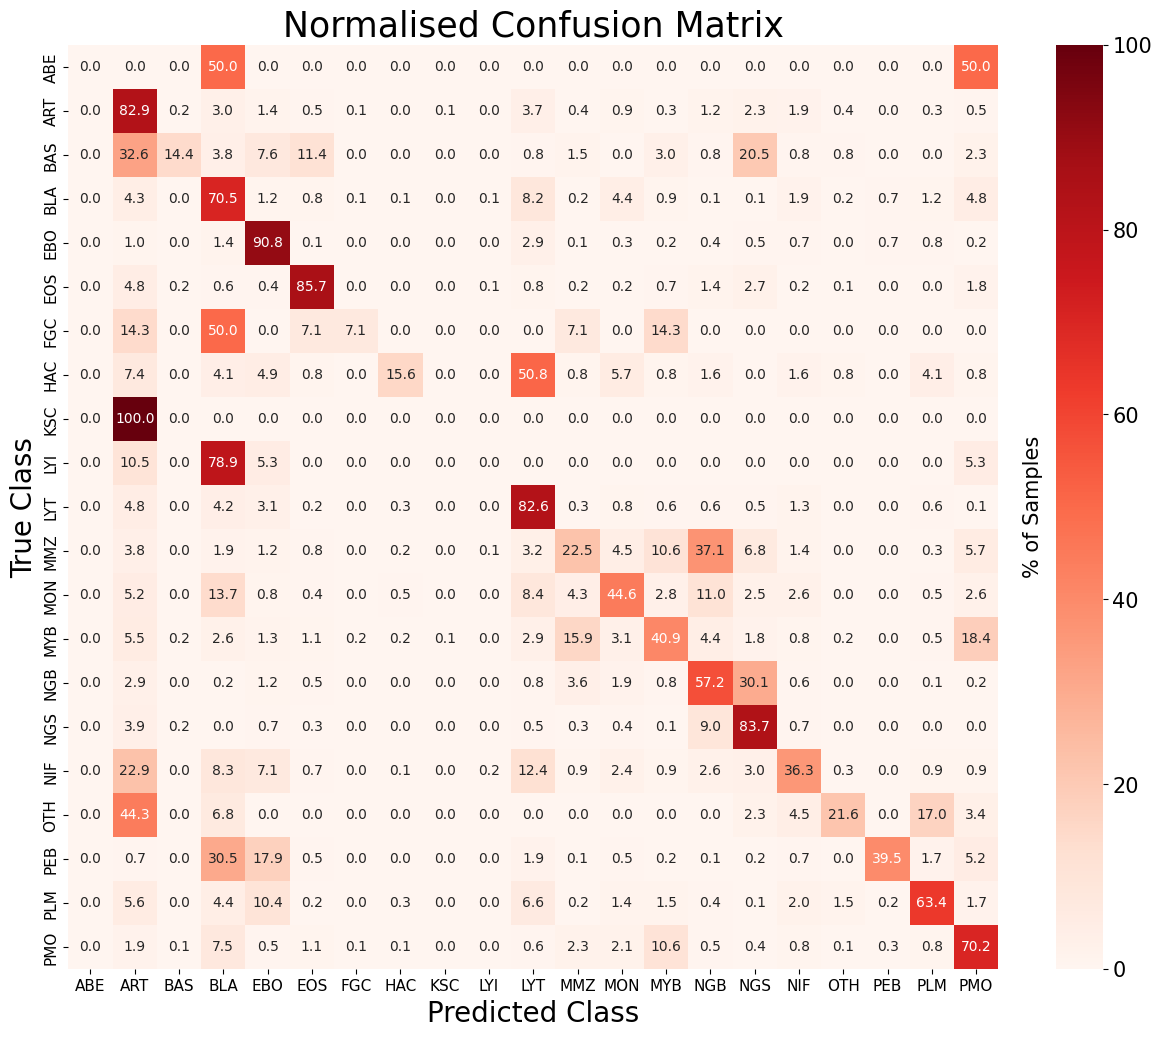

In [12]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [13]:
with open(os.path.join(folder, inner_folder, 'test_classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder, 'test_confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'test_normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

# 2. Optimised Model Metrics

In [14]:
folder = 'pickle'
inner_folder = 'optimised'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

In [15]:
reset_metrics()
y_true, y_pred = predict(model)

In [16]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.7589098215103149


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         2
         ART       0.71      0.86      0.78      5889
         BAS       0.67      0.03      0.06       132
         BLA       0.69      0.58      0.63      3591
         EBO       0.90      0.90      0.90      8218
         EOS       0.96      0.76      0.85      1764
         FGC       0.00      0.00      0.00        14
         HAC       0.28      0.04      0.07       122
         KSC       0.00      0.00      0.00        12
         LYI       0.00      0.00      0.00        19
         LYT       0.81      0.86      0.83      7872
         MMZ       0.34      0.18      0.24       916
         MON       0.56      0.46      0.50      1212
         MYB       0.65      0.34      0.45      1967
         NGB       0.53      0.68      0.60      2990
         NGS       0.86      0.84      0.85      8826
         NIF       0.56      0.29      0.38      1061
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


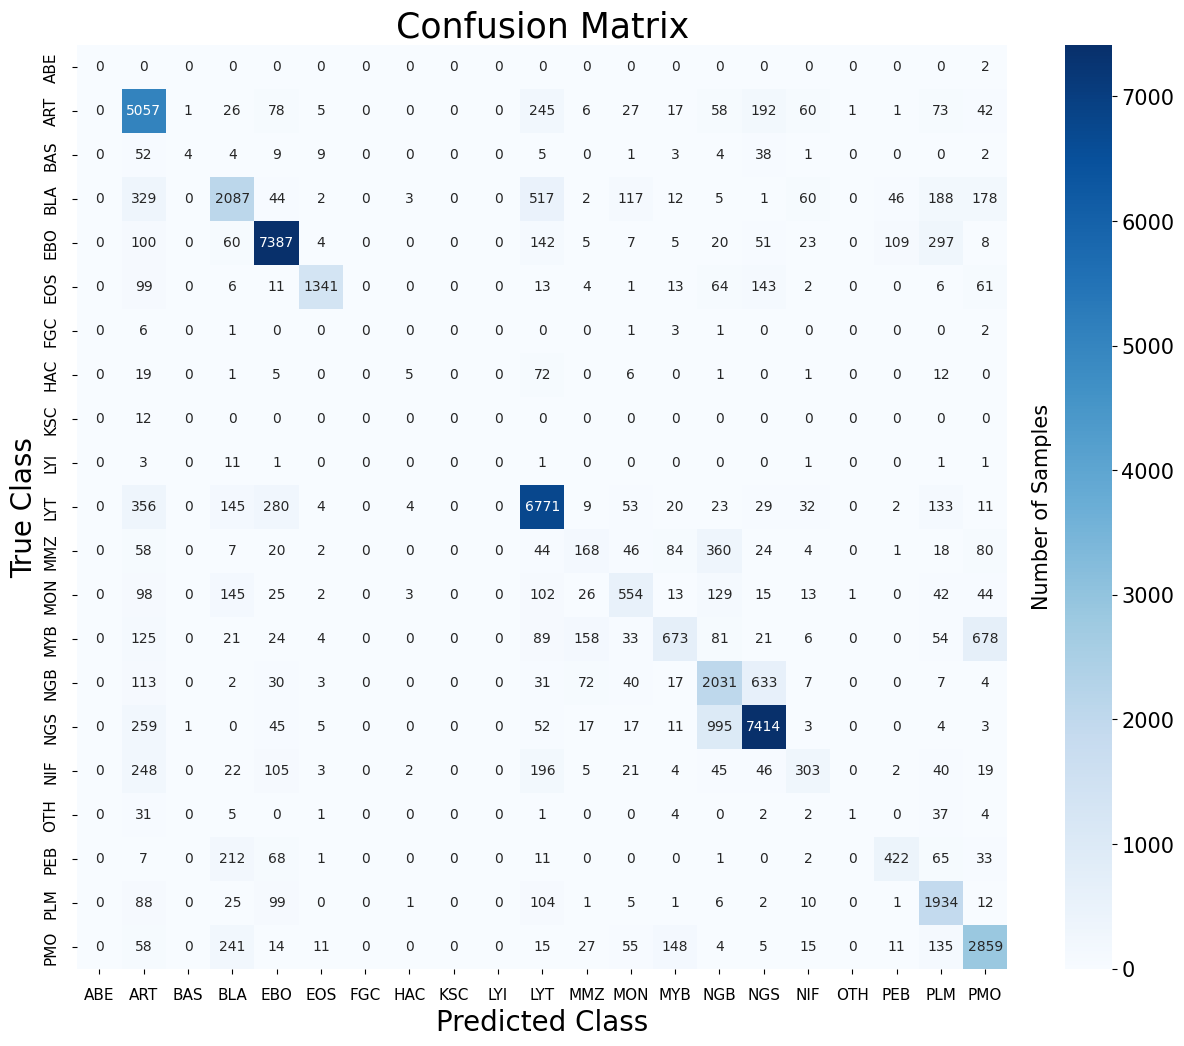

In [17]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

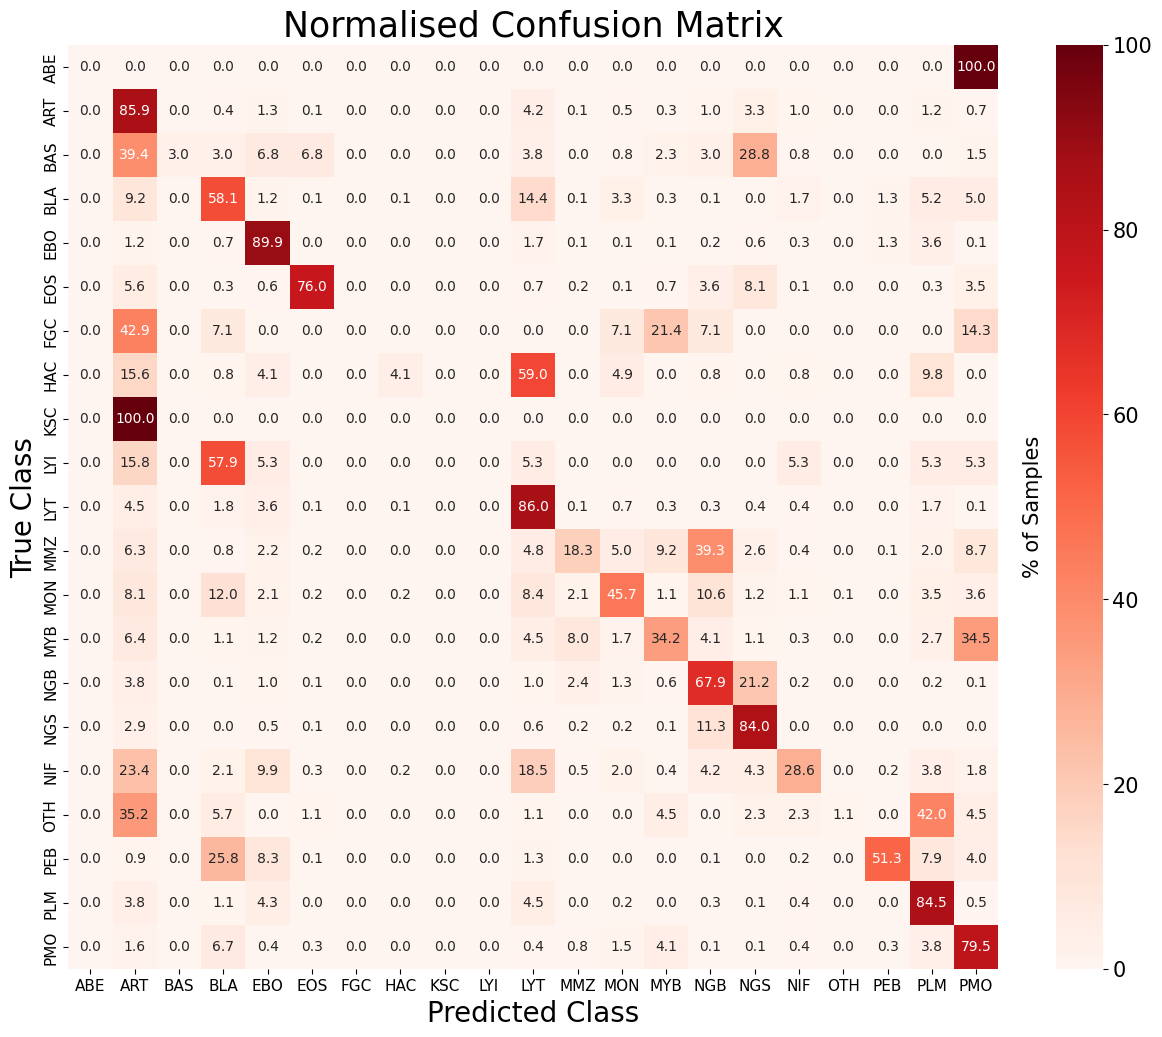

In [18]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [19]:
with open(os.path.join(folder, inner_folder, 'test_classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder, 'test_confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'test_normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

# 3. Optimised Model (With Data Augmentation) Metrics

In [20]:
folder = 'pickle'
inner_folder = 'augmented_2'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)

In [21]:
reset_metrics()
y_true, y_pred = predict(model)

In [22]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.782857358455658
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         2
         ART       0.85      0.77      0.81      5889
         BAS       0.19      0.64      0.29       132
         BLA       0.76      0.68      0.72      3591
         EBO       0.88      0.92      0.90      8218
         EOS       0.91      0.93      0.92      1764
         FGC       0.05      0.14      0.07        14
         HAC       0.27      0.58      0.37       122
         KSC       0.32      0.83      0.47        12
         LYI       0.13      0.37      0.20        19
         LYT       0.86      0.83      0.85      7872
         MMZ       0.33      0.49      0.40       916
         MON       0.50      0.70      0.58      1212
         MYB       0.63      0.58      0.60      1967
         NGB       0.58      0.66      0.62      2990
         NGS       0.90      0.81      0.86      8826
         NIF       0.56      0

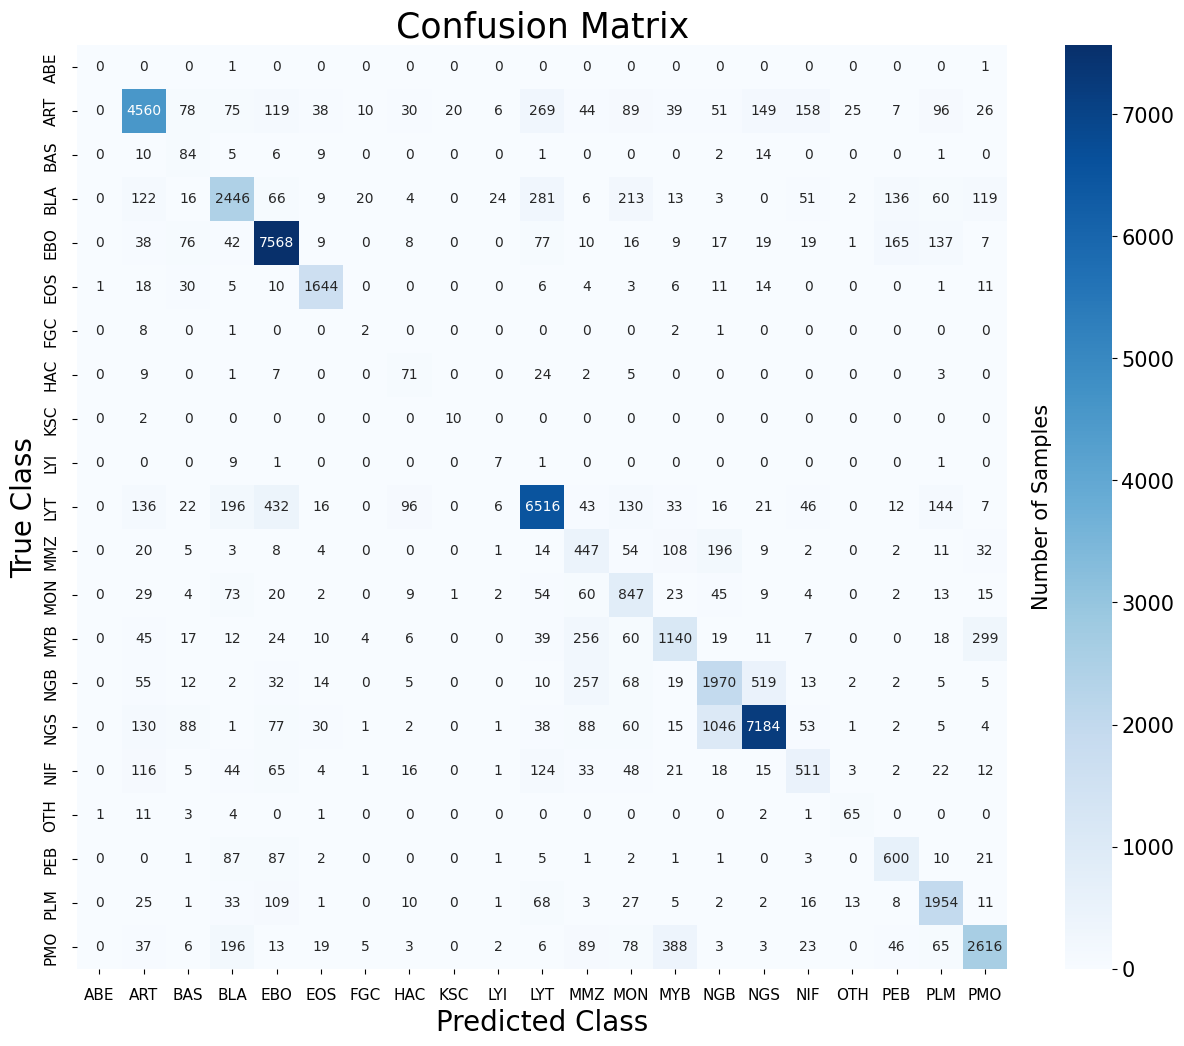

In [24]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

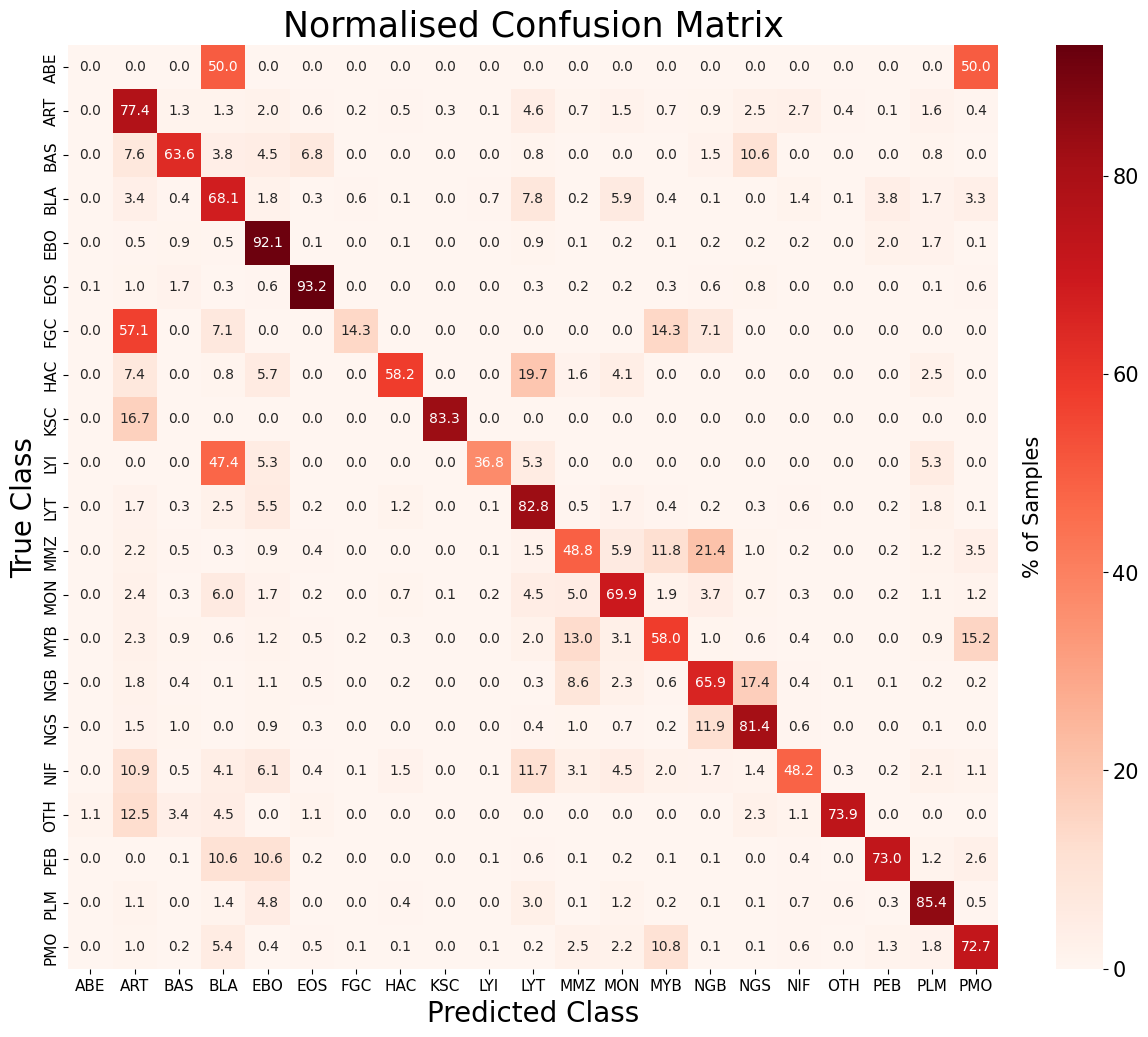

In [25]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [26]:
with open(os.path.join(folder, inner_folder, 'test_classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder, 'test_confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'test_normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)